In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline 

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7)

In [2]:
arr04 = np.load("AA00400AA.npy",allow_pickle=True)
arr64 = np.load("AA66466AA.npy",allow_pickle=True)

In [36]:
print(arr04.shape, arr64.shape)

(17751,) (75040,)


In [20]:
len_df._64.argmax()

39702

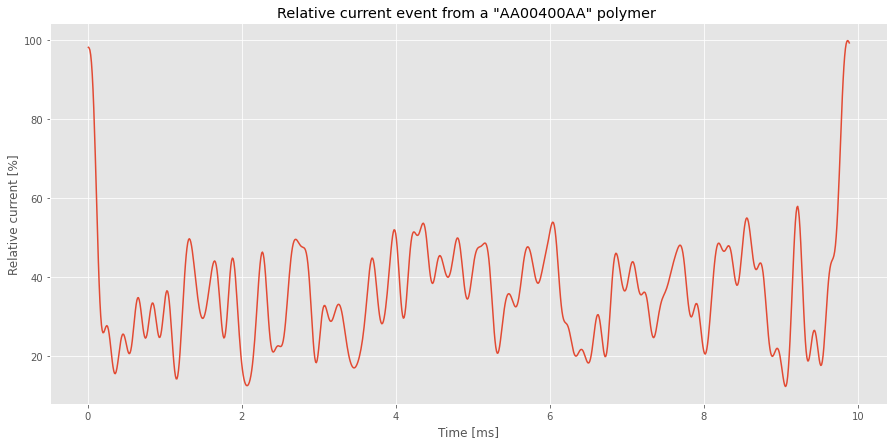

In [35]:
obs = arr04[0]
time = obs[:,0]
current = obs[:,1]

g = sns.lineplot(x=time,y=current)

g.set_xlabel("Time [ms]")
g.set_ylabel("Relative current [%]")
g.set_title("Relative current event from a \"AA00400AA\" polymer ")
plt.savefig("test.png",dpi=300)

### Exploration and plotting

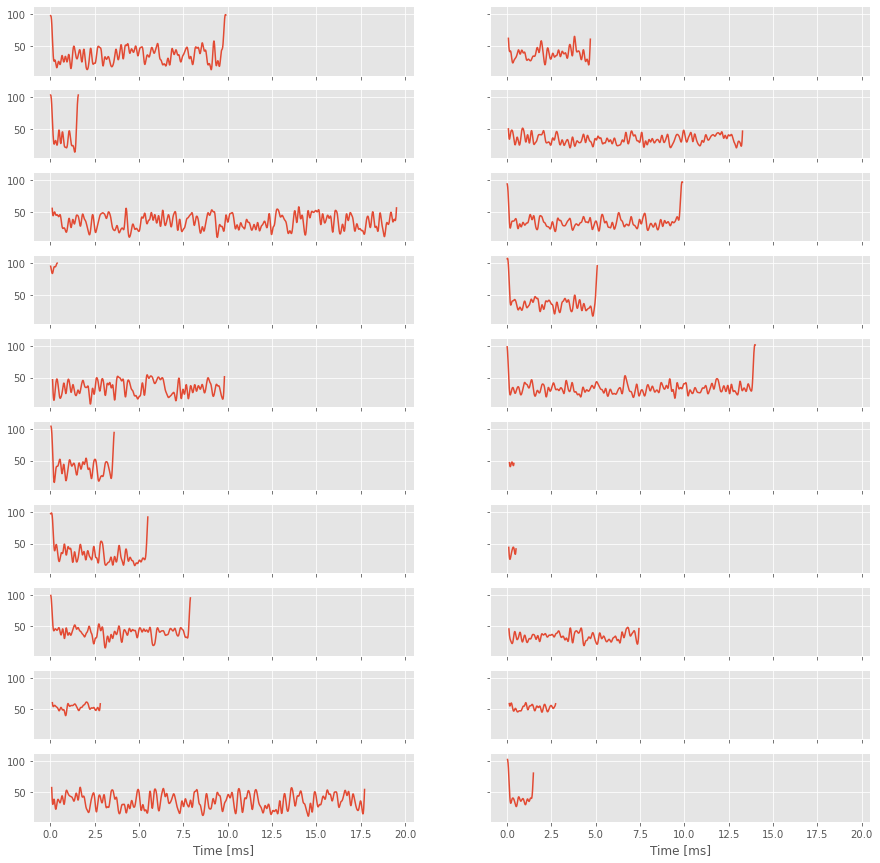

In [3]:
k = 10
fig, axes = plt.subplots(k,2, figsize=(15,15), sharex=True, sharey=True)

for i in range(k):
    obs = arr04[i]
    time = obs[:,0]
    current = obs[:,1]

    g= sns.lineplot(x=time,y=current, ax=axes[i][0])
    g.set_xlabel("Time [ms]")

    obs = arr64[i]
    time = obs[:,0]
    current = obs[:,1]

    g= sns.lineplot(x=time,y=current, ax=axes[i][1])
    g.set_xlabel("Time [ms]")



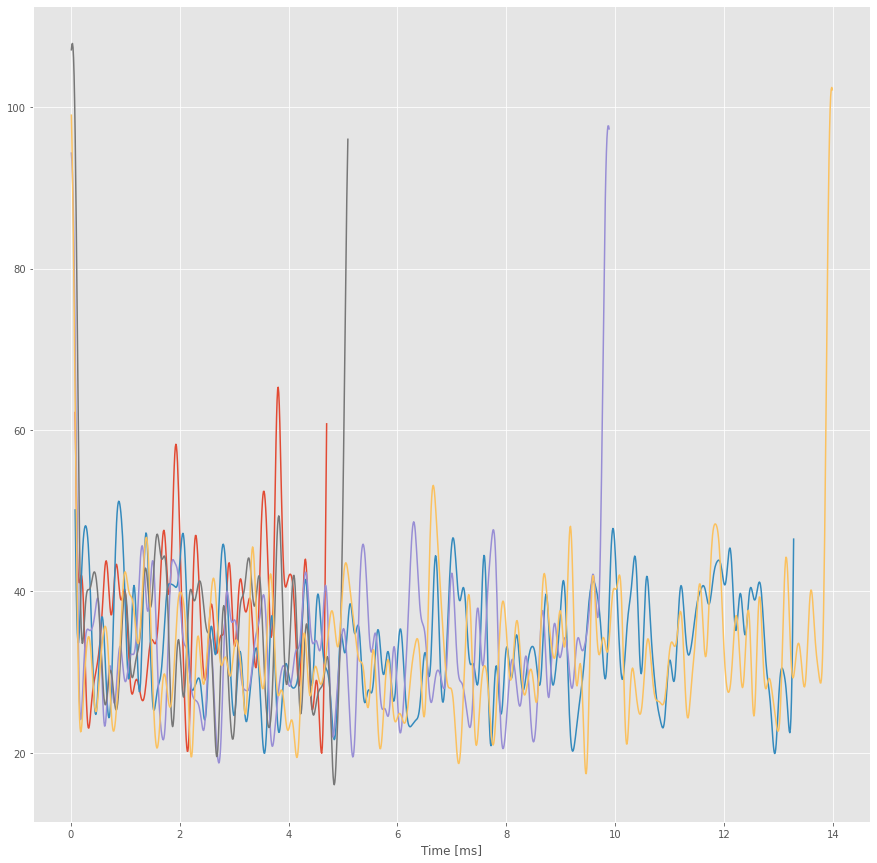

In [4]:
k = 5
fig, axes = plt.subplots(1,1, figsize=(15,15), sharex=True,)

for i in range(k):
    obs = arr64[i]
    time = obs[:,0]
    current = obs[:,1]

    g= sns.lineplot(x=time,y=current)
    g.set_xlabel("Time [ms]")

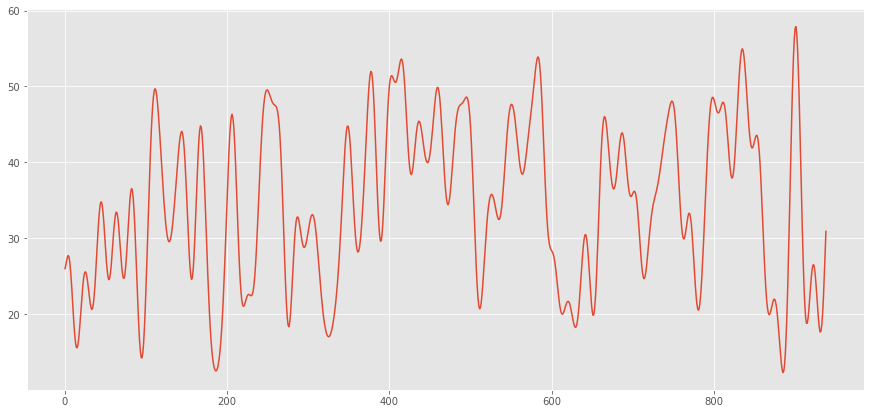

In [19]:
plt.plot(current[20:-30])

### Frequency analysis

In [66]:
obs = arr04[0]
time = obs[:,0]
current = obs[:,1]


def PSD(current):
    
    dt = 0.01
    n = len(current)
    fhat = np.fft.fft(current,n) # compute FFT
    PSD = (fhat * np.conj(fhat)) / n # Power spectrum 
    PSD = np.real(PSD)
    freq = (1/(dt*n))* np.arange(n) # X-axis of frequencies
    L = np.arange(1,np.floor(n/2),dtype='int') # Only plot the first half of the PSD

    return freq[L], PSD[L]


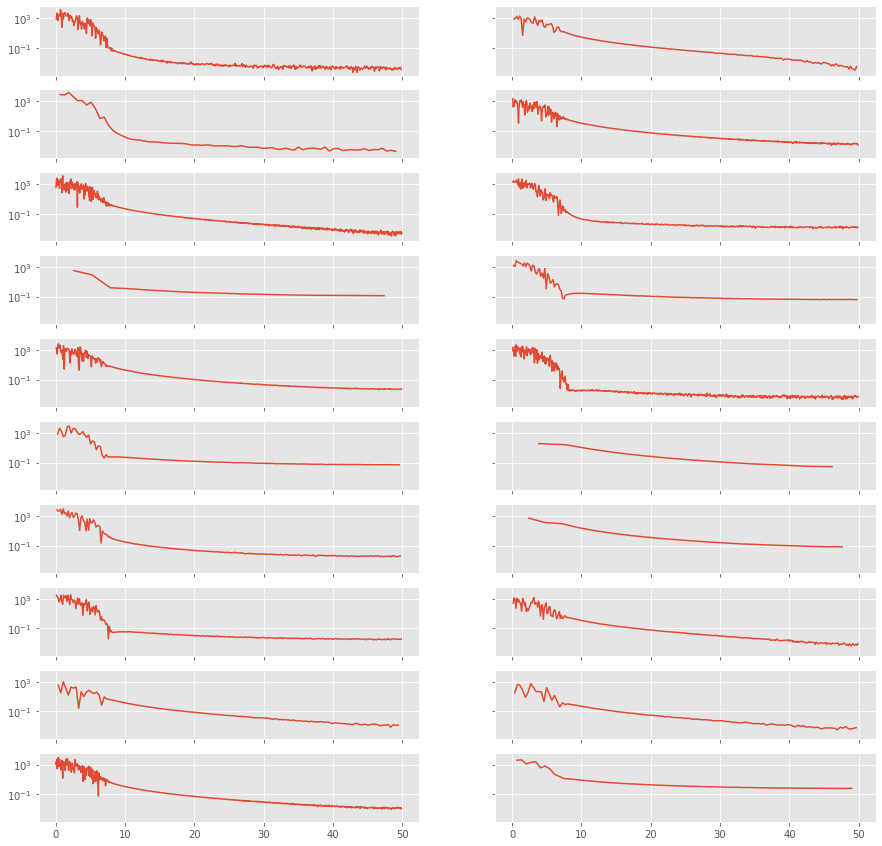

In [67]:
k = 10
fig, axes = plt.subplots(k,2, figsize=(15,15), sharex=True, sharey=True)

for i in range(k):
    obs = arr04[i]
    time = obs[:,0]
    current = obs[:,1]

    freq, psd = PSD(current)
    plt.axes(axes[i][0])
    plt.plot(freq,psd)
    plt.yscale("log")

    obs = arr64[i]
    time = obs[:,0]
    current = obs[:,1]

    freq, psd = PSD(current)
    plt.axes(axes[i][1])
    plt.plot(freq,psd)
    plt.yscale("log")

## Dimensionality reduction

### Exploratory data analysis
Let's look for dirty data. We expect many current time series to be too short

In [40]:
np.isnan(np.NaN)

True

In [41]:
np.isnan(lengths).sum()

0

In [13]:
lengths = []

for row in arr04:
    curr = row.shape[0]
    if np.isnan(curr):
        print(row)
    lengths.append(curr)

lengths2 = []

for row in arr64:
    lengths2.append(row.shape[0])



lengths = pd.Series(lengths, name = '_04')
lengths2 = pd.Series(lengths2, name = '_64')

len_df = pd.concat([lengths,lengths2], axis = 1)
len_df.describe()

,_04,_64
count,17751.000000,75040.000000
mean,450.688975,1217.319616
std,733.848421,2588.741758
min,8.000000,8.000000
25%,99.000000,228.000000
50%,259.000000,649.000000
75%,602.000000,1459.000000
max,45974.000000,208579.000000


In [17]:
len_df._04.argmax()

13385

As we can see, the '64' dataset has about 4 times more data. Furthermore, the mean and median length are both larger for the '64' dataset.
Thus, if we use the raw dataset, it might be possible that we could yield a fairly good accuracy just looking at the length of the sequence. Furthermore, the two datasets are unbalanced, the model might have an incentive to always output '64' and he will obtain 70% accuracy.

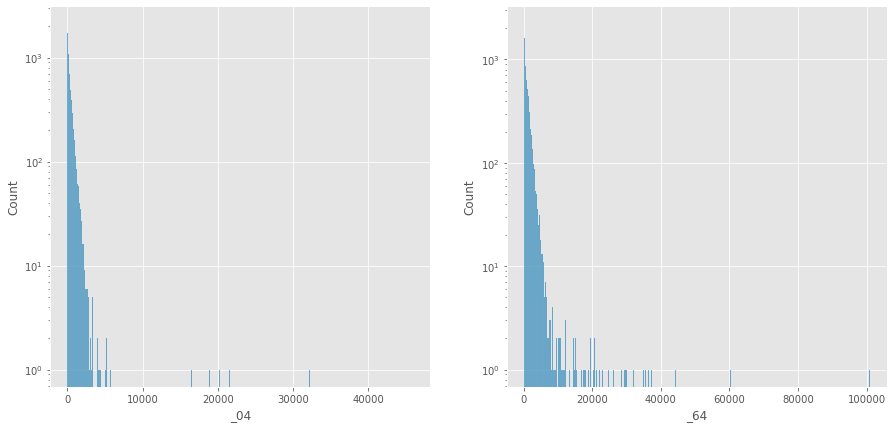

In [9]:
f,a = plt.subplots(1,2, figsize=(15,7),sharex=False)

g=sns.histplot(x='_04',data=len_df, ax=a[0])

g.set_yscale('log')

g=sns.histplot(x='_64',data=len_df.iloc[:len(arr04)], ax=a[1])
g.set_yscale('log')


Looking at the plot, we understand that it might be desirable to discard two things:

- The current signals from '64' that are much longer than the entirety of the dataset.
- Discard signals with less than 1 extremum

In [49]:
extremums = []

for row in arr04:
    curr = count_extremums(row[:,1])
    extremums.append(curr)

extremums2 = []

for row in arr64:
    curr = count_extremums(row[:,1])
    extremums2.append(curr)



extremums = pd.Series(extremums, name = '_04')
extremums2 = pd.Series(extremums2, name = '_64')

extremum_df = pd.concat([extremums,extremums2], axis = 1)
extremum_df.describe()

,_04,_64
count,17751.000000,75040.000000
mean,32.316377,90.358795
std,54.741025,195.595535
min,1.000000,1.000000
25%,7.000000,17.000000
50%,19.000000,48.000000
75%,43.000000,107.000000
max,3533.000000,15491.000000


C:\Users\Harold\anaconda3\lib\site-packages\seaborn\distributions.py:154: UserWarning: The handle <matplotlib.patches.Patch object at 0x000002A717581C10> has a label of '_04' which cannot be automatically added to the legend.
  ax_obj.legend(handles, labels, title=self.variables["hue"], **legend_kws)
C:\Users\Harold\anaconda3\lib\site-packages\seaborn\distributions.py:154: UserWarning: The handle <matplotlib.patches.Patch object at 0x000002A717581CD0> has a label of '_64' which cannot be automatically added to the legend.
  ax_obj.legend(handles, labels, title=self.variables["hue"], **legend_kws)


<AxesSubplot:ylabel='Count'>

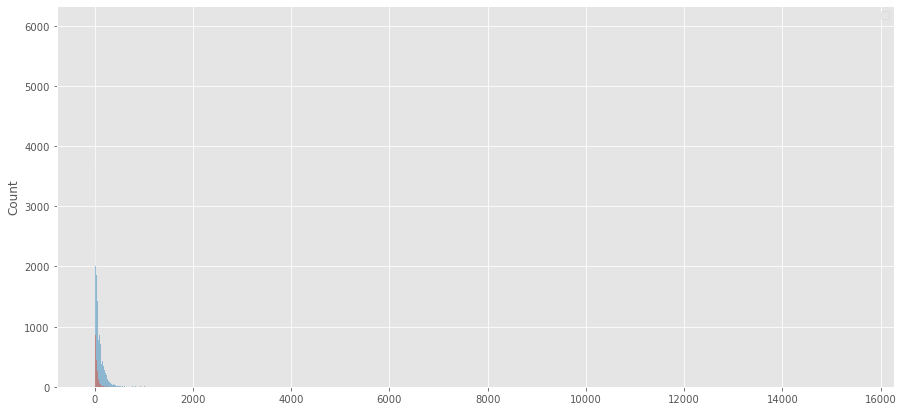

In [69]:
sns.histplot(extremum_df)

In [68]:
print(lengths.quantile(0.1),lengths.quantile(0.9))

47.0 1059.0


In [65]:
df_04 = pd.concat([pd.Series(arr04), lengths, extremums], axis=1)
df_04.columns = ['current','length','extremums']
df_64 = pd.concat([pd.Series(arr64), lengths2, extremums2], axis=1)
df_64.columns = ['current','length','extremums']

In [66]:
df_04

,current,length,extremums
0,"[[0.01, 98.11744], [0.02, 97.95397], [0.03, 97...",989,76
1,"[[0.01, 103.79977], [0.02, 103.34829], [0.03, ...",157,11
2,"[[0.1, 55.49999], [0.11, 51.39003], [0.12, 48....",1942,141
3,"[[0.01, 95.29184], [0.02, 94.20208], [0.03, 92...",38,3
4,"[[0.12, 46.657352], [0.13, 39.060158], [0.14, ...",970,67
...,...,...,...
17746,"[[0.07, 50.085503], [0.08, 42.08189], [0.09, 3...",1171,81
17747,"[[0.1, 70.49723], [0.11, 68.84449], [0.12, 67....",57,3
17748,"[[0.13, 50.99996], [0.14, 46.863922], [0.15, 4...",897,63
17749,"[[0.01, 102.14254], [0.02, 103.11573], [0.03, ...",39,3


In [52]:
## filtering the length to be below the '04' 90% quantile
length_upper = df_04.length.quantile(0.9)
length_lower = 



,_04,_64
0,989.0,463
2,1942.0,989
3,38.0,509
5,357.0,26
6,549.0,42
...,...,...
75032,NaN,564
75035,NaN,339
75036,NaN,67
75037,NaN,349


### Naive SVM classifier

Here, we don't balance the dataset and there is no filtering of short events

In [46]:
def count_extremums(current):
    increasing = current[0]<current[1]
    tmp=current[0]
    counter = 0
    values=[]
    for i in current[1:]:
        if increasing and i<tmp:
            increasing = False
            counter +=1
            values.append(i)
        elif not increasing and i>tmp:
            increasing=True
            counter+=1
            values.append(i)

        tmp=i
    return counter


def extract_features(row):
    length=row.shape[0]
    current=row[:,1]
    mean_current=np.mean(current)
    max_current=np.max(current)
    min_current=np.min(current)
    extremum_count=count_extremums(current)
    return (length, mean_current, max_current, min_current, extremum_count)


In [ ]:
row = arr64[0]

In [ ]:
row.shape[0]

463

In [ ]:
def get_extracted_features(arr, plot=False):
    lengths=[]
    means=[]
    maxs=[]
    mins=[]
    extremum_counts=[]
    
    for row in arr:
        length, mean_current, max_current, min_current, extremum_count=extract_features(row)
        lengths.append(length)
        means.append(mean_current)
        maxs.append(max_current)
        mins.append(min_current)
        extremum_counts.append(extremum_count)
    if plot:
        fig, axes = plt.subplots(5,1, figsize=(15,30))
        sns.histplot(lengths, ax=axes[0]).set_title("lengths")
        sns.histplot(means, ax=axes[1]).set_title("means")
        sns.histplot(maxs, ax=axes[2]).set_title("maxs")
        sns.histplot(mins, ax=axes[3]).set_title("mins")
        sns.histplot(extremum_counts, ax=axes[4]).set_title("extremum counts")
    return np.array([np.array(lengths),np.array(means),np.array(maxs),np.array(mins),np.array(extremum_counts)])

In [ ]:
X04= get_extracted_features(arr04).T

In [ ]:
X64 = get_extracted_features(arr64).T

In [ ]:
X=np.concatenate((X04, X64))
Y=np.concatenate((np.zeros(len(X04)),np.ones(len(X64))))

In [ ]:
from sklearn import svm, model_selection

In [ ]:
X_train, X_test, y_train, y_test=model_selection.train_test_split(X,Y, train_size=0.7, random_state=3)

clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
clf.score(X_test,y_test)

0.8825705869674546

### Deep Learning

In [6]:
import torch
from torch.utils.data import Dataset

In [4]:
x = torch.Tensor([5,3])
y= torch.Tensor([2,1])

In [6]:
x=torch.zeros((2,5))
x

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [8]:
x =torch.randn((2,5))
x

tensor([[ 1.6696, -0.5118,  0.7545, -1.5292, -0.7514],
        [ 0.5131, -0.5073,  0.6762,  0.3016, -0.2973]])

In [12]:
x = x.view((-1,10))
x

tensor([[ 1.6696, -0.5118,  0.7545, -1.5292, -0.7514,  0.5131, -0.5073,  0.6762,
          0.3016, -0.2973]])

In [5]:
import torchvision
from torchvision import transforms, datasets

In [7]:
train = datasets.MNIST("",train=True, download=False,
transform= transforms.Compose([transforms.ToTensor()]))

test= datasets.MNIST("",train=False, download=False,
transform= transforms.Compose([transforms.ToTensor()]))

In [8]:
trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

testset = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True)

In [9]:
for data in trainset:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [18]:
x,y = data[0][0], data[1][0]

In [21]:
x.shape

torch.Size([1, 28, 28])

In [10]:
import torch.nn as nn
import torch.nn.functional as F 

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # dimensions of input (flattened 28 by 28 image)
        # 64 neurons
        # Linear is fully connected
        self.fc1 = nn.Linear(28*28,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        # final layer with 10 classes
        self.fc4 = nn.Linear(64,10)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # dim is like axis, defines the axis on which we want the prob distrib to sum to 1
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x 

    

In [13]:
net = Net()

In [12]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr= 0.001)

EPOCHS = 3

for epoch in range(EPOCHS):
    for data in trainset:
        # data is a batch of features and labels
        X,y = data
        net.zero_grad()
        output = net(X.view(-1, 28*28))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        
    print(loss)


NameError: name 'net' is not defined

In [43]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testset:
        X,y = data
        output = net(X.view(-1,28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            
            total += 1

print(f"Accuracy: ", {correct/total})

Accuracy:  {0.9713}


## Using GPUS

In [50]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


In [61]:
net = Net().cuda()

In [62]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr= 0.001)

EPOCHS = 3


for epoch in range(EPOCHS):
    for data in trainset:
        # data is a batch of features and labels
        X,y = data
        X = X.cuda()
        y= y.cuda()
        net.zero_grad()
        output = net(X.view(-1, 28*28))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        
    print(loss)

tensor(0.2566, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1975, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1212, device='cuda:0', grad_fn=<NllLossBackward0>)


In [64]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testset:
        X,y = data
        X = X.cuda()
        y= y.cuda()
        output = net(X.view(-1,28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            
            total += 1

print(f"Accuracy: ", {correct/total})

Accuracy:  {0.9633}
